# stLearn

In this notebook, we tested stSME clustering algorithm from stLearn tool on PDAC B2 data. It identifies spatial domains from three ST data types : Spatial distance, tissue Morphology, and gene Expression measurements (SME).

The tutorial : https://stlearn.readthedocs.io/en/latest/tutorials/stSME_clustering.html

# 1. Installation

pip install -U stlearn

# 2. Preparation

In [1]:
# import module
import stlearn as st
from pathlib import Path
st.settings.set_figure_params(dpi=180)

In [11]:
# specify PATH to data
BASE_PATH = Path("./visiopharm/visium/PDAC_B2")

# spot tile is the intermediate result of image pre-processing
TILE_PATH = Path("./stLearn/tiles")
TILE_PATH.mkdir(parents=True, exist_ok=True)

# output path
OUT_PATH = Path("./stLearn/output")
OUT_PATH.mkdir(parents=True, exist_ok=True)

In [12]:
# load data
data = st.Read10X(BASE_PATH)

/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [13]:
# pre-processing for gene count table
st.pp.filter_genes(data,min_cells=1)
st.pp.normalize_total(data)
st.pp.log1p(data)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X


In [14]:
# pre-processing for spot image
st.pp.tiling(data, TILE_PATH)

# this step uses deep learning model to extract high-level features from tile images
# may need few minutes to be completed
st.pp.extract_feature(data)

Tiling image: 100%|██████████ [ time left: 00:00 ]
2023-05-26 12:00:36.163174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 12:00:36.290919: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-26 12:00:36.290956: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-26 12:00:36.965891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cann

94765736/94765736 [==============================] - 1s 0us/step


Extract feature: 100%|██████████ [ time left: 00:00 ]


The morphology feature is added to adata.obsm['X_morphology']!


# 3. run stSME clustering

In [15]:
# run PCA for gene expression data
st.em.run_pca(data,n_comps=50)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


In [16]:
data_SME = data.copy()
# apply stSME to normalise log transformed data
st.spatial.SME.SME_normalize(data_SME, use_data="raw")
data_SME.X = data_SME.obsm['raw_SME_normalized']
st.pp.scale(data_SME)
st.em.run_pca(data_SME,n_comps=50)

Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by SME is added to adata.obsm['raw_SME_normalized']
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Applying Kmeans cluster ...
Kmeans cluster is done! The labels are stored in adata.obs["kmeans"]


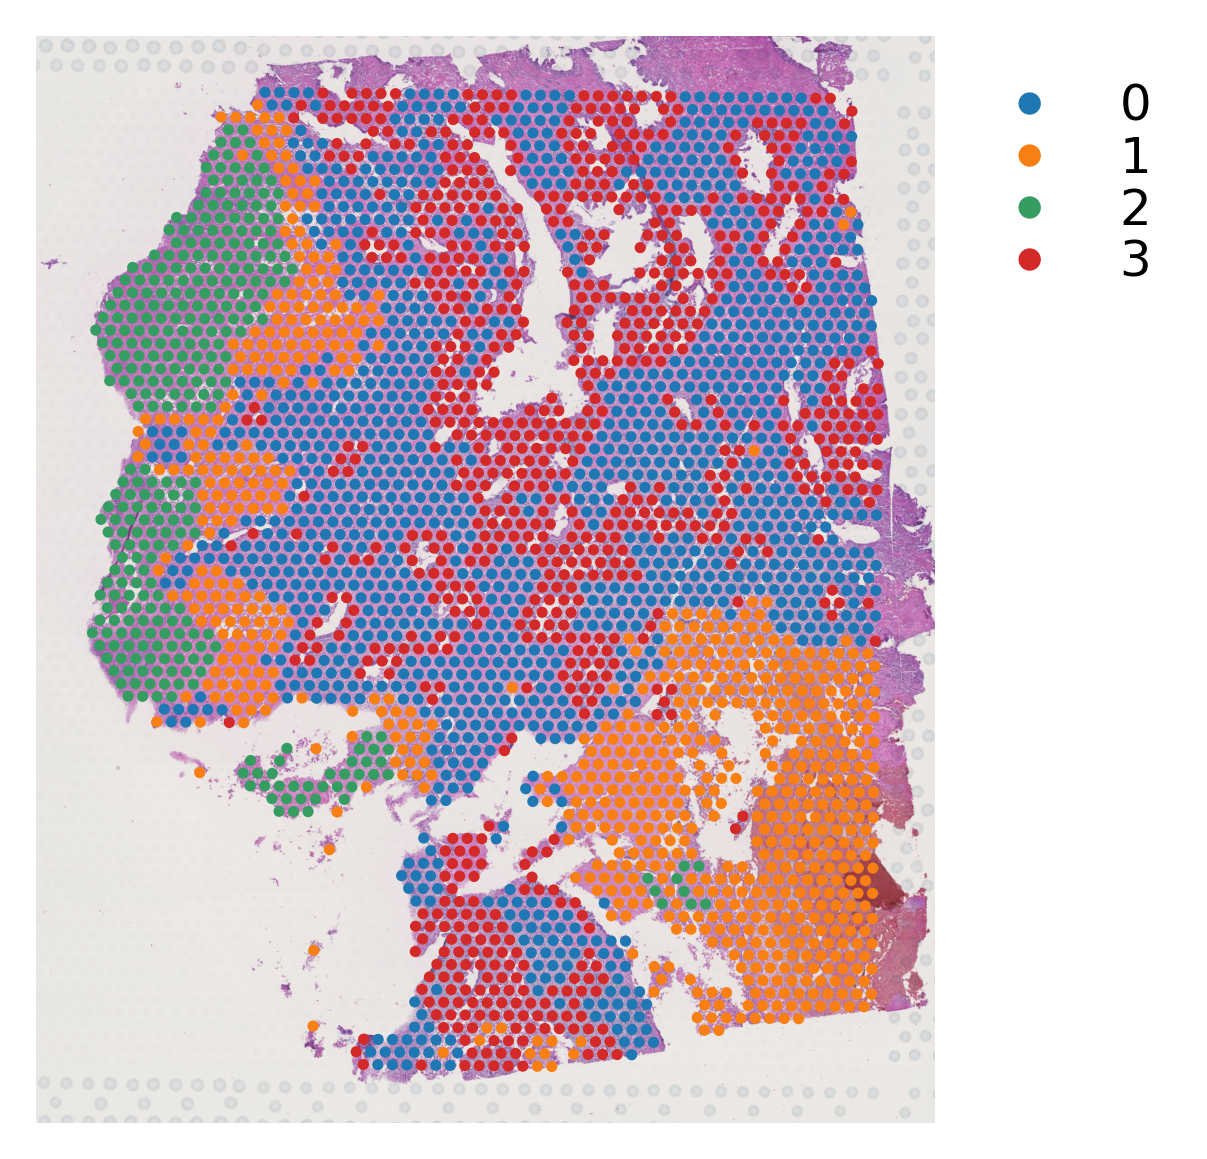

In [17]:
# K-means clustering on stSME normalised PCA
st.tl.clustering.kmeans(data_SME,n_clusters=4, use_data="X_pca", key_added="X_pca_kmeans")
st.pl.cluster_plot(data_SME, use_label="X_pca_kmeans")

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


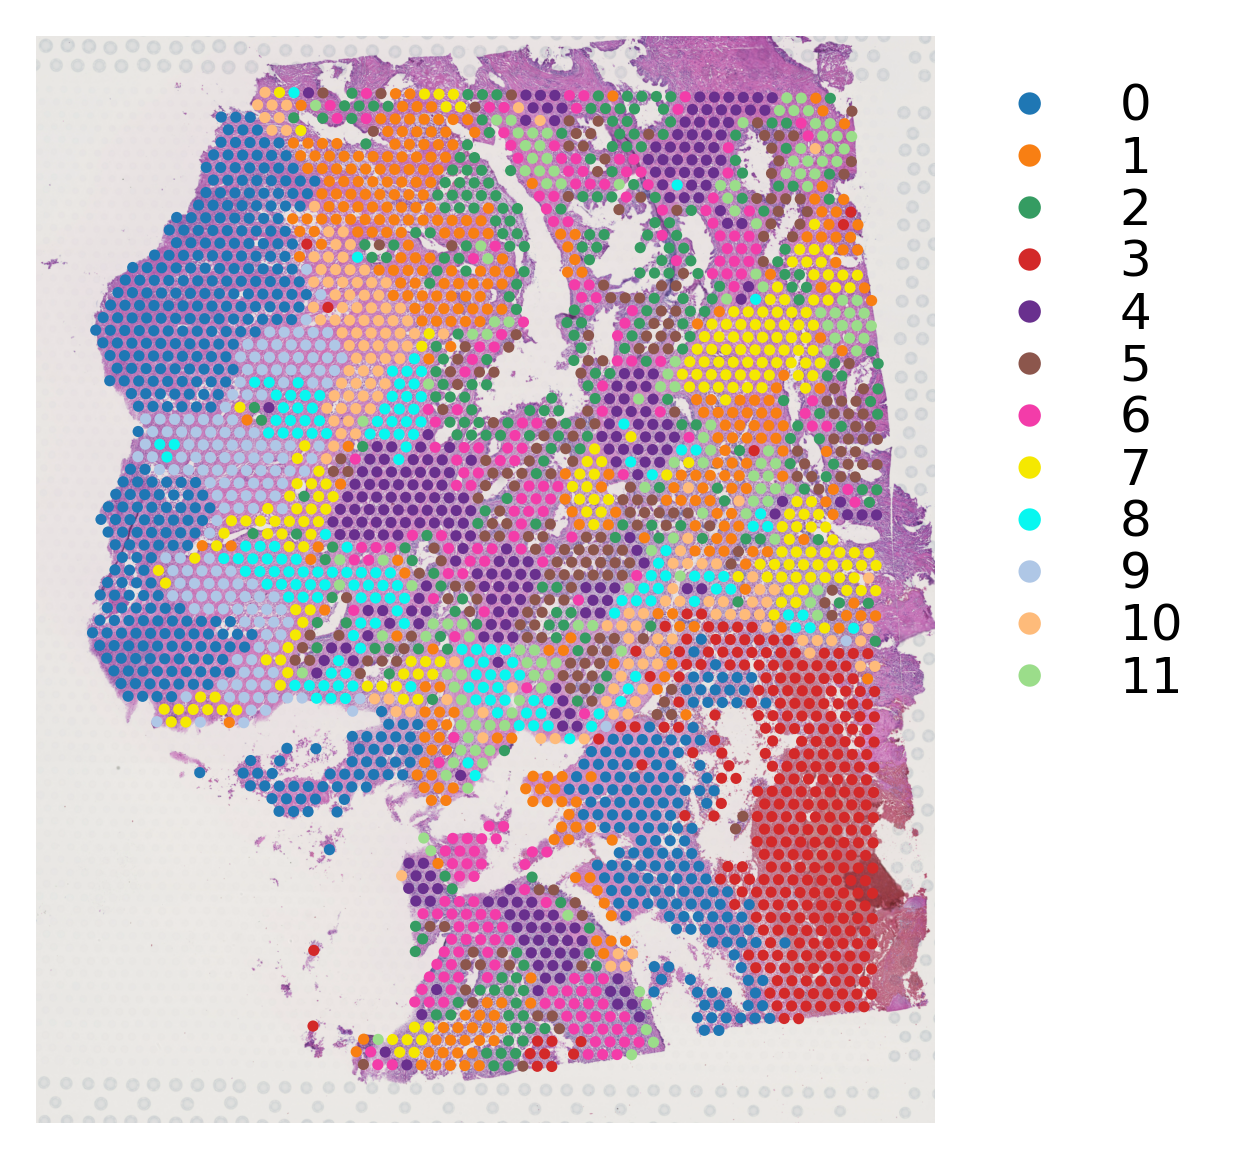

In [18]:
# louvain clustering on stSME normalised data
st.pp.neighbors(data_SME,n_neighbors=17,use_rep='X_pca')
st.tl.clustering.louvain(data_SME, resolution=1.19)
st.pl.cluster_plot(data_SME,use_label="louvain")